In [1]:
import numpy as np
import pandas as pd
import unidecode

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

from nlp_tweets.preprocess import clean_text

from nlp_tweets.eda import get_categorial_confusion_matrix, plot_roc_curve_mean

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yannhallouard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
PATH_RAW = '../data/raw/'
PATH_PROCESSED = '../data/processed/'

TRAIN_COLUMNS = ['id', 'text', 'target']
TEST_COLUMNS = ['id', 'text']

# Loading

In [3]:
tweets_df = pd.read_csv(PATH_RAW + 'train.csv')
tweets_df = tweets_df[TRAIN_COLUMNS]
tweets_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweets_test_df = pd.read_csv(PATH_RAW + 'test.csv')
tweets_test_df = tweets_test_df[TEST_COLUMNS]

# Preprocessing

In [5]:
to_remove_caracters = ['/', '-', '[', ']', ',', ':', '&', '>', '<', '\\', '#']

stops = list(stopwords.words("english")) + list(stopwords.words("french"))
stops = [unidecode.unidecode(stop_words) for stop_words in stops]
stop_words = ['']
stop_words += stops

In [6]:
tweets_df['text']      = tweets_df['text'].apply(clean_text(to_remove_caracters, 
                                                       stop_words))
tweets_test_df['text'] = tweets_test_df['text'].apply(clean_text(to_remove_caracters, 
                                                       stop_words))

In [7]:
tweets_test_df['text']

0                                happen terribl car crash
1         heard earthquak differ citi stay safe everyone.
2       forest fire spot pond gees flee across street ...
3                      apocalyps lighting. spokan wildfir
4                      typhoon soudelor kill china taiwan
                              ...                        
3258     earthquak safeti los angel uo safeti fasten xrwn
3259    storm ri wors last hurricane. citi amp; other ...
3260                            green line derail chicago
3261                  meg issu hazard weather outlook hwo
3262     cityofcalgari activ municip emerg plan. yycstorm
Name: text, Length: 3263, dtype: object

In [9]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    words = [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]
    return words

In [10]:
vectorizer = TfidfVectorizer(tokenizer = tokenize, max_features = 1000)

X_train = vectorizer.fit_transform(tweets_df['text'].values)
X_to_pred  = vectorizer.transform(tweets_test_df['text'].values)
words = vectorizer.get_feature_names()

# Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_train, tweets_df['target'], test_size=0.4)

print(X_train.shape, X_test.shape)

(4567, 1000) (3046, 1000)


# Create Model

## Baseline

In [12]:
baseline_model = DummyClassifier(strategy="most_frequent")

### Train

In [13]:
baseline_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

### Test

In [14]:
baseline_pre_on_test = baseline_model.predict(X_test)

In [15]:
baseline_mae = mean_absolute_error(y_test, baseline_pre_on_test)
print(f'The mae for the baseline on test set is {baseline_mae}')

The mae for the baseline on test set is 0.43007222586999344


array([[1736.],
       [1310.]])

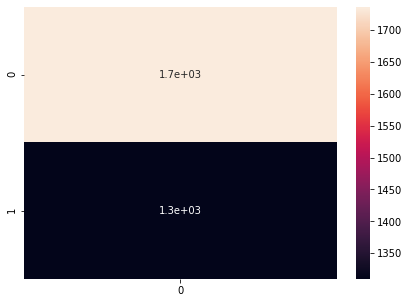

In [16]:
get_categorial_confusion_matrix(y_test, baseline_pre_on_test, display=True)

# Random forest

In [69]:
xgb_model = GradientBoostingRegressor(n_estimators=500)

### Train

In [70]:
xgb_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=500)

### Finding the best threshold

In [71]:
pred_proba_train = xgb_model.predict(X_train)
pred_proba_test = xgb_model.predict(X_test)

Train Accuracy: 0.899277425005474 
Train Confusion Matrix:
[[2560   46]
 [ 414 1547]]
Test Accuracy: 0.7734734077478661 
Test Confusion Matrix:
[[1524  212]
 [ 478  832]]


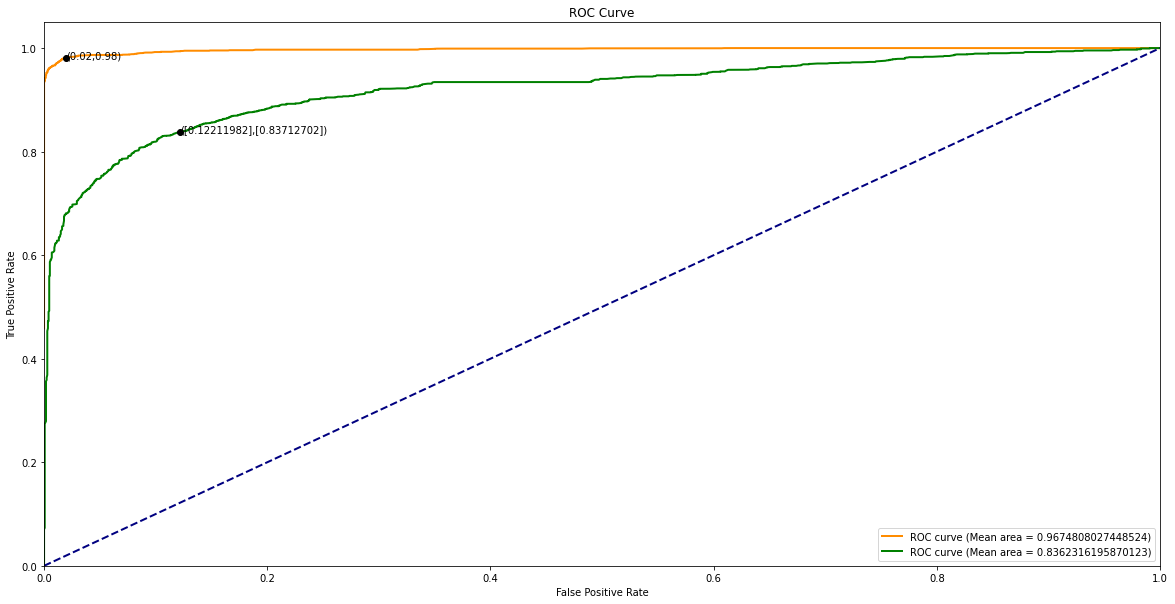

In [72]:
threshold = plot_roc_curve_mean(y_train=y_train.values, y_train_pred_proba=pred_proba_train, 
                        y_test=y_test.values, y_test_pred_proba=pred_proba_test)

### Test

In [73]:
model_pred_on_test = xgb_model.predict(X_test)
model_pred_on_test = (model_pred_on_test > threshold).astype(int)

In [74]:
xgb_mae = mean_absolute_error(y_test, model_pred_on_test)
print(f'The mae for the baseline on test set is {xgb_mae}')

The mae for the baseline on test set is 0.22652659225213395


array([[1524.,  212.],
       [ 478.,  832.]])

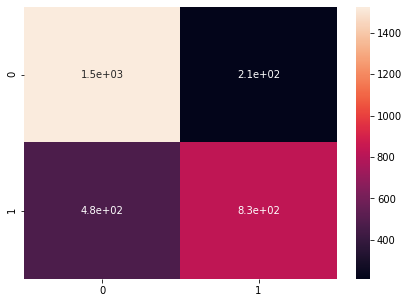

In [75]:
get_categorial_confusion_matrix(y_test, model_pred_on_test, display=True)

# Predict

In [76]:
predictions = xgb_model.predict(X_to_pred)
predictions = (predictions > threshold).astype(int)

In [77]:
output = pd.read_csv(PATH_RAW + 'sample_submission.csv')
output['target'] = predictions
output.to_csv(PATH_PROCESSED + 'to_submit.csv', index=False)